# Machine Learning: Logistic Regression

**Author:** Ravneet-Rahul Sandhu Singh

**Date:** 02/11/2025

In [9]:
library(data.table)
library(broom)
library(ResourceSelection)
library(DT)
library(MASS)
library(ggplot2)
library(ggpubr)
library(caTools)
library(pROC)
library(vip)
library(caret)

In [10]:
# Load the dataset
# https://stackoverflow.com/questions/18001120/what-is-the-practical-difference-between-data-frame-and-data-table-in-r
df <- fread("../data/thyroid_diff.csv")
setDT(df)

In [11]:
# Convert character columns to factors
cols_to_factor <- names(df)[sapply(df, is.character)]
df[, (cols_to_factor) := lapply(.SD, as.factor), .SDcols = cols_to_factor]

summary(df)

# Releveling descriptive factors
df$Gender <- relevel(df$Gender, ref = "F")
df$Smoking <- relevel(df$Smoking, ref = "No")
df$`Hx Smoking` <- relevel(df$`Hx Smoking`, ref = "No")
df$`Hx Radiothreapy` <- relevel(df$`Hx Radiothreapy`, ref = "No")

# 'Euthyroid' is the most common state
df[, Thyroid_Function_Simple := fcase(
  `Thyroid Function` == "Euthyroid", "Euthyroid",
  `Thyroid Function` %like% "Hypo", "Hypothyroidism",
  `Thyroid Function` %like% "Hyper", "Hyperthyroidism"
)]
df$Thyroid_Function_Simple <- as.factor(df$Thyroid_Function_Simple)
df$Thyroid_Function_Simple <- relevel(
  df$Thyroid_Function_Simple,
  ref = "Euthyroid"
)

# 'Normal' is the logical clinical baseline
df[, Physical_Exam_Simple := fcase(
  `Physical Examination` == "Normal", "Normal",
  `Physical Examination` %like% "Single nodular", "Single Nodule",
  `Physical Examination` == "Multinodular goiter", "Multinodular Goiter",
  `Physical Examination` == "Diffuse goiter", "Diffuse Goiter"
)]
df$Physical_Exam_Simple <- as.factor(df$Physical_Exam_Simple)
df$Physical_Exam_Simple <- relevel(df$Physical_Exam_Simple, ref = "Normal")

# 'No' involvement is the logical baseline
df[, Adenopathy_Binary := fcase(
  Adenopathy == "No", "No",
  default = "Yes"
)]
df$Adenopathy_Binary <- as.factor(df$Adenopathy_Binary)
df$Adenopathy_Binary <- relevel(df$Adenopathy_Binary, ref = "No")

# 'Papillary' is the most common type
# https://www.ncbi.nlm.nih.gov/books/NBK536943/
df[, Pathology_Simple := fcase(
  Pathology == "Follicular", "Follicular",
  Pathology == "Hurthel cell", "Hurthel cell",
  Pathology == "Papillary", "Papillary",
  Pathology == "Micropapillary", "Papillary"
)]
df$Pathology_Simple <- as.factor(df$Pathology_Simple)
df$Pathology_Simple <- relevel(df$Pathology_Simple, ref = "Papillary")

# Focality
df$Focality <- relevel(df$Focality, ref = "Uni-Focal")

# 'Low' is the logical baseline and most common
df$Risk <- relevel(df$Risk, ref = "Low")

# 'T1a' is the lowest/earliest T stage
df$T <- relevel(df$T, ref = "T1a")

# 'N0' is no node involvement, the logical baseline
df$N <- relevel(df$N, ref = "N0")

# 'M0' is no metastasis, the logical baseline
df$M <- relevel(df$M, ref = "M0")

# 'I' is the earliest stage and the logical baseline
df$Stage <- relevel(df$Stage, ref = "I")

# 'Excellent' is the logical baseline
df$Response <- relevel(df$Response, ref = "Excellent")

# Set 'No' as the baseline for 'Recurred'
df$Recurred <- relevel(df$Recurred, ref = "No")

      Age        Gender  Smoking   Hx Smoking Hx Radiothreapy
 Min.   :15.00   F:312   No :334   No :355    No :376        
 1st Qu.:29.00   M: 71   Yes: 49   Yes: 28    Yes:  7        
 Median :37.00                                               
 Mean   :40.87                                               
 3rd Qu.:51.00                                               
 Max.   :82.00                                               
                                                             
                    Thyroid Function                  Physical Examination
 Clinical Hyperthyroidism   : 20     Diffuse goiter             :  7      
 Clinical Hypothyroidism    : 12     Multinodular goiter        :140      
 Euthyroid                  :332     Normal                     :  7      
 Subclinical Hyperthyroidism:  5     Single nodular goiter-left : 89      
 Subclinical Hypothyroidism : 14     Single nodular goiter-right:140      
                                                      

In [12]:
# Split data
set.seed(42)
split <- sample.split(df$Recurred, SplitRatio = 0.8)
df_train <- df[split == TRUE, ]
df_test <- df[split == FALSE, ]

# Define model

# Baseline:
# formula <- Recurred ~ Age + Gender + Smoking +
#   `Hx Smoking` + `Hx Radiothreapy` + Thyroid_Function_Simple +
#   Physical_Exam_Simple + Adenopathy_Binary + Pathology_Simple +
#   Focality + Risk + T + N + M + Stage + Response

# To get the correct ORs run with:
# formula <- Recurred ~ Age + Gender + Smoking + `Hx Smoking` +
#   `Hx Radiothreapy` + Thyroid_Function_Simple + Adenopathy_Binary +
#   Pathology_Simple + Focality + N

# Define formula:
# The parameters were selected based on different runs and the final model only
# contains those that produced a stable model.
formula <- Recurred ~ Age + Gender +
  Adenopathy_Binary + Pathology_Simple + Focality

# Fit model
model <- glm(
  formula,
  data = df_train,
  family = binomial(link = "logit")
)

# Deviance and AIC
# print(summary(model))

# Hosmer-Lemeshow Test
# hl_test <- hoslem.test(model$y,
#   model$fitted.values,
#   g = 10
# )
# print(hl_test)

# Print ORs and CI table
# or_table <- tidy(model, exponentiate = TRUE, conf.int = TRUE)
# fwrite(or_table, file = "../results/odds_ratios.csv")

# Interpretation:
#
# Risk Factors (Odds Ratio > 1):
#
# Adenopathy_BinaryYes (OR = 27.10, p < 0.0001): This is the most dominant
# predictor. Having any lymph node involvement (vs. none) increases the odds of
# recurrence by over 27 times.
#
# Pathology_SimpleFollicular (OR = 5.44, p = 0.0022): Patients with Follicular
# cancer have over 5.4 times the odds of recurrence compared to the reference
# category (Papillary/Micropapillary).
#
# GenderM (OR = 3.91, p = 0.0064): Male patients have nearly 4 times the odds
# of recurrence compared to female patients.
#
# FocalityMulti-Focal (OR = 2.56, p = 0.0063): A tumor in multiple spots (vs. a
# single spot, Uni-Focal) has 2.5 times the odds of recurrence.
#
# Age (OR = 1.04, p = 0.0009): For every one-year increase in age, the odds of
# recurrence increase by 4%.
#
# Non-Significant Factors (p >= 0.05):
#
# Smoking and `Hx Smoking`: Neither was significant.
#
# `Hx Radiothreapy`: This was not significant (p=0.3379).
#
# Thyroid_Function_Simple: None of the thyroid states were significantly
# different from Euthyroid (normal).
#
# Pathology_SimpleHurthel cell: In this model, Hurthel cell (p=0.4582) was not
# statistically different from the Papillary reference group.
#
# I did not consider Adenopathy and N at the same time because they were
# providing similar information.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Setting levels: control = No, case = Yes

Setting direction: controls < cases



Area under the curve: 0.9223


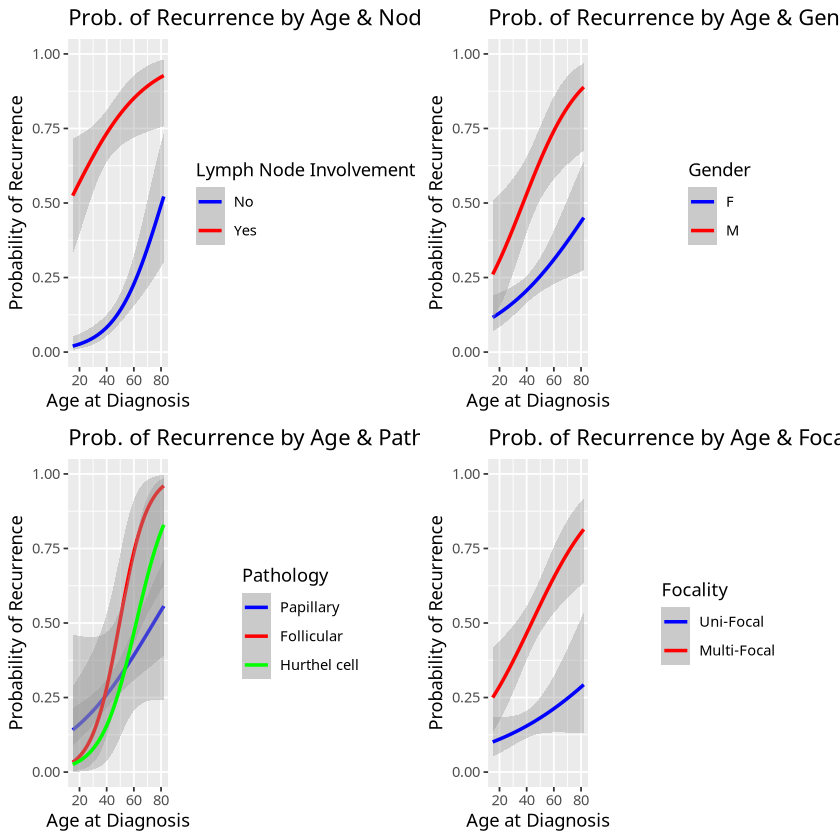

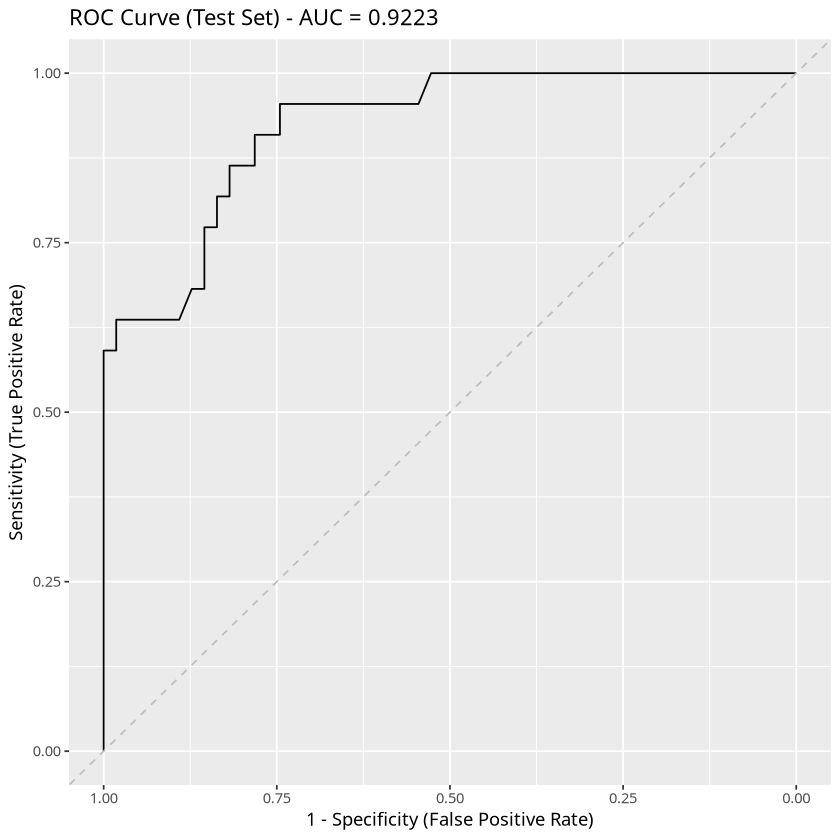

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  41   1
       Yes 14  21
                                          
               Accuracy : 0.8052          
                 95% CI : (0.6991, 0.8867)
    No Information Rate : 0.7143          
    P-Value [Acc > NIR] : 0.046750        
                                          
                  Kappa : 0.5946          
                                          
 Mcnemar's Test P-Value : 0.001946        
                                          
            Sensitivity : 0.9545          
            Specificity : 0.7455          
         Pos Pred Value : 0.6000          
         Neg Pred Value : 0.9762          
             Prevalence : 0.2857          
         Detection Rate : 0.2727          
   Detection Prevalence : 0.4545          
      Balanced Accuracy : 0.8500          
                                          
       'Positive' Class : Yes             
                                 

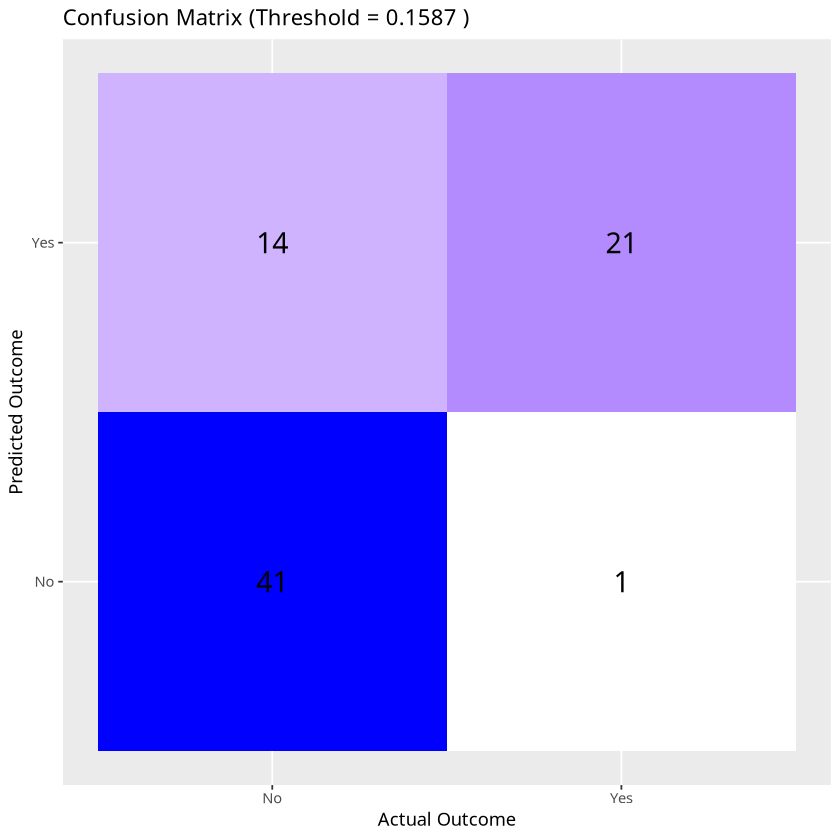

In [13]:
# Age vs. Recurrence, split by Adenopathy
plot_curve_adenopathy <- ggplot(
  df,
  aes(x = Age, y = as.numeric(Recurred) - 1, color = Adenopathy_Binary)
) +
  geom_smooth(
    method = "glm",
    method.args = list(family = "binomial"),
    se = TRUE,
    fullrange = TRUE
  ) +
  scale_y_continuous(
    limits = c(0, 1),
    breaks = seq(0, 1, 0.25),
    name = "Probability of Recurrence"
  ) +
  scale_color_manual(
    values = c("No" = "blue", "Yes" = "red"),
    name = "Lymph Node Involvement"
  ) +
  labs(
    title = "Prob. of Recurrence by Age & Node Status",
    x = "Age at Diagnosis"
  )

# Age vs. Recurrence, split by Gender
plot_curve_gender <- ggplot(
  df,
  aes(x = Age, y = as.numeric(Recurred) - 1, color = Gender)
) +
  geom_smooth(
    method = "glm",
    method.args = list(family = "binomial"),
    se = TRUE,
    fullrange = TRUE
  ) +
  scale_y_continuous(
    limits = c(0, 1),
    breaks = seq(0, 1, 0.25),
    name = "Probability of Recurrence"
  ) +
  scale_color_manual(
    values = c("F" = "blue", "M" = "red"),
    name = "Gender"
  ) +
  labs(
    title = "Prob. of Recurrence by Age & Gender",
    x = "Age at Diagnosis"
  )

# Age vs. Recurrence, split by Focality
plot_curve_focality <- ggplot(
  df,
  aes(x = Age, y = as.numeric(Recurred) - 1, color = Focality)
) +
  geom_smooth(
    method = "glm",
    method.args = list(family = "binomial"),
    se = TRUE,
    fullrange = TRUE
  ) +
  scale_y_continuous(
    limits = c(0, 1),
    breaks = seq(0, 1, 0.25),
    name = "Probability of Recurrence"
  ) +
  scale_color_manual(
    values = c("Uni-Focal" = "blue", "Multi-Focal" = "red"),
    name = "Focality"
  ) +
  labs(
    title = "Prob. of Recurrence by Age & Focality",
    x = "Age at Diagnosis"
  )

# Age vs. Recurrence, split by Pathology
plot_curve_pathology <- ggplot(
  df,
  aes(x = Age, y = as.numeric(Recurred) - 1, color = Pathology_Simple)
) +
  geom_smooth(
    method = "glm",
    method.args = list(family = "binomial"),
    se = TRUE,
    fullrange = TRUE
  ) +
  scale_y_continuous(
    limits = c(0, 1),
    breaks = seq(0, 1, 0.25),
    name = "Probability of Recurrence"
  ) +
  scale_color_manual(
    values = c(
      "Follicular" = "red",
      "Papillary" = "blue",
      "Hurthel cell" = "green"
    ),
    name = "Pathology"
  ) +
  labs(
    title = "Prob. of Recurrence by Age & Pathology",
    x = "Age at Diagnosis"
  )

# Combine plots
combined_plot <- ggarrange(
  plot_curve_adenopathy,
  plot_curve_gender,
  plot_curve_pathology,
  plot_curve_focality,
  ncol = 2,
  nrow = 2,
  common.legend = FALSE,
  align = "hv"
)
print(combined_plot)

# Odds Ratios
# or_table_filtered <- or_table[or_table$term != "(Intercept)", ]
# plot_or <- ggplot(or_table_filtered, aes(x = estimate, y = term)) +
#   geom_point() +
#   geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
#   geom_vline(xintercept = 1, linetype = "dashed", color = "red") +
#   scale_x_log10() +
#   labs(
#     title = "Odds Ratios for Recurrence",
#     x = "Odds Ratio (log scale)",
#     y = "Predictor"
#   )
# print(plot_or)

# ROC Curve
pred_prob_test <- predict(model, newdata = df_test, type = "response")
roc_obj <- roc(df_test$Recurred, pred_prob_test)
auc_value <- auc(roc_obj)
print(auc_value)
plot_roc <- ggroc(roc_obj) +
  geom_abline(slope = 1, intercept = 1, linetype = "dashed", color = "grey") +
  labs(
    title = paste("ROC Curve (Test Set) - AUC =", round(auc_value, 4)),
    x = "1 - Specificity (False Positive Rate)",
    y = "Sensitivity (True Positive Rate)"
  )
print(plot_roc)

# Confusion Matrix
# Our primary goal was inference to understand the relationships and calculate
# valid odds ratios. This is why we build the model on the real imbalanced data
# (to get the true relationships) and then find the optimal threshold to
# correct for the imbalance when making predictions.
optimal_threshold <- coords(roc_obj, "best", ret = "threshold")$threshold
pred_class <- factor(
  ifelse(pred_prob_test > optimal_threshold, "Yes", "No"),
  levels = c("No", "Yes")
)
cm <- confusionMatrix(pred_class, df_test$Recurred, positive = "Yes")
plot_cm <- ggplot(
  as.data.frame(cm$table), aes(x = Reference, y = Prediction, fill = Freq)
) +
  geom_tile() +
  geom_text(aes(label = Freq), size = 6) +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(
    title = paste(
      "Confusion Matrix (Threshold =", round(optimal_threshold, 4), ")"
    ),
    x = "Actual Outcome",
    y = "Predicted Outcome"
  ) +
  theme(legend.position = "none")
print(plot_cm)
print(cm)